In [1]:
from final_exp_res18_s8 import * 
import torch
from torch import nn
from mmdetv2.models.ganet import GANet
from ganet_head import GANetHeadFast
from lanepoints_conv import LanePointsConv
from dcn_fpn import DeformFPN
from resnet import ResNet
from mmdetv2.losses.ganetloss import LaneLossAggress
from mmdetv2.datasets.culane_dataset import CulaneDataset
from mmdetv2.runner.checkpoint import load_checkpoint
from mmdetv2.runner.test_dataset import *
from mmcv.parallel import MMDataParallel
from mmdet.datasets.builder import build_dataloader
from mmdetv2.utils.vis import DataVis
from utils.converters import get
import pdb

data_cfg = data

# get GANet:
gpu_id = [0]
model_dst = work_dir + '/epoch_60.pth'
net_cfg = get(model)
net = MMDataParallel(GANet(**net_cfg), gpu_id)
state_dict = None 
state_dict = load_checkpoint(net, model_dst, map_location='cpu',strict=True)
try:
    del state_dict
except NameError:
    pass
net.eval()    # important!!!!
print(f"load state_dict from: {model_dst}, GANet has been in eval mode")

# get dataset:
culane = CulaneDataset(**get(data_cfg['test']))
data_loader = build_dataloader(
    culane,1,1,shuffle=False
)
# viser = DataVis(inline=True)

/disk/zhangyunzhi/anaconda3/envs/ganet/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-20 22:54:39,550 - root - INFO - load model from: torchvision://resnet18
2023-01-20 22:54:39,754 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias



load state_dict from: ./work_dirs/culane/fine-tuning/epoch_60.pth, GANet has been in eval mode


In [2]:
isinstance(net, MMDataParallel)

True

### batch size can only be 1 in test dataloader!

In [3]:
res = []
for i, data in enumerate(data_loader):
    # if i> 100:
    with torch.no_grad():
        output = net(**data, return_loss=False, inference=True, hm_thr=0.3, kpt_thr=0.4, cpt_thr=0.4, decoder=None)
        if i % 7 == 0:
            res.append({'data':data, 'out':output})
        if len(res) > 7:
            break

In [10]:
output

{'start_point_hm': tensor([[[[9.9990e-01, 1.0000e-04, 9.9990e-01,  ..., 1.4843e-02,
            1.6134e-01, 9.9990e-01],
           [9.9990e-01, 1.0000e-04, 9.9990e-01,  ..., 9.9990e-01,
            9.9990e-01, 9.9990e-01],
           [9.9990e-01, 1.0000e-04, 9.9990e-01,  ..., 9.9990e-01,
            9.9990e-01, 9.9990e-01],
           ...,
           [9.9989e-01, 1.8280e-04, 6.2628e-01,  ..., 3.7561e-01,
            8.1523e-04, 9.9990e-01],
           [9.9621e-01, 9.9990e-01, 9.9990e-01,  ..., 9.9899e-01,
            4.3654e-01, 9.9990e-01],
           [9.9990e-01, 9.9990e-01, 9.9990e-01,  ..., 9.9981e-01,
            9.9990e-01, 9.9701e-01]]]], device='cuda:0'),
 'kpts_hm': tensor([[[[1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 9.1780e-03,
            8.5521e-03, 1.2227e-02],
           [1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 8.2818e-03,
            8.1595e-03, 1.0827e-02],
           [1.0000e-04, 1.0000e-04, 1.0000e-04,  ..., 7.0434e-03,
            7.7719e-03, 9.3122e-03],
       

In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline

def get_numpy(t):
    if hasattr(t, 'data'):
        t = t.data
    if isinstance(t, torch.Tensor):
        return t.cpu().numpy()
    return t
idx = 5
data_item = res[idx]['out']
data_gt = res[idx]['data']
[k for k in data_item], [k for k in data_gt]

(['start_point_hm',
  'kpts_hm',
  'offset',
  'error',
  'start_points',
  'kpts_points'],
 ['img_metas',
  'img',
  'gt_cpts_hm',
  'gt_kpts_hm',
  'int_offset',
  'pts_offset',
  'gt_masks',
  'lane_points_l0',
  'lane_points_l1',
  'lane_points_l2',
  'offset_mask',
  'offset_mask_weight',
  'gt_vp_hm'])

In [8]:
data_gt['img_metas'].data[0][0]['sub_img_name'][:-3]

'/driver_100_30frame/05251517_0433.MP4/01050.'

- data_item['kpts_points']: numpy.ndarray
- data_item['kpts_points']: list  
- data_item['start_point_hm']: Tensor[1,1,40,100]
- data_item['kpts_hm']: Tensor[1,1,40,100]
- data_item['offset']: Tensor[1,2,40,100]
- data_item['error']: Tensor[1,2,40,100]

(40, 100)


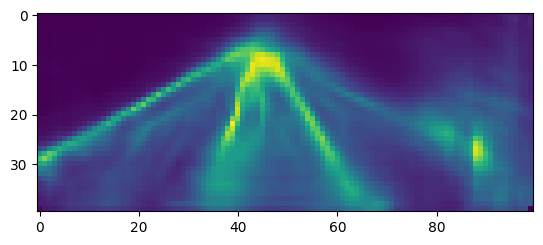

In [4]:
import os 
import cv2
from utils.converters import *
from PIL import Image 
from utils.show_lanes import draw_kpts, draw_lanes_on_img, show_thr_mask, show_hist
from utils.heatmap import read_lane_lines
# path = data_gt['img_metas'].data[0][0]['filename'][:-3] + 'lines.txt'
# os.path.exists(path)
img = np.array(Image.open(get_img_path(data=data_gt)))
txt_path = get_txt_path(data_gt)
lines = read_lane_lines(txt_path)
kpts = draw_kpts(lines)
hm = get_hm(data_item)
print(hm.shape)
plt.imshow(hm)

In [5]:
# show_hist(hm - hm.min())
from utils.inference_tool import inference, scale_up

In [6]:
np.array(np.where(np.array([[0,0,1,0],[0,1,0,0],[1,0,0,1]]))).T

array([[0, 2],
       [1, 1],
       [2, 0],
       [2, 3]])

In [27]:
points = inference(hm)

In [32]:
points[0].shape

(20, 2)

In [43]:
# img = np.zeros((590, 1640))
with open('out.txt','w') as f:  
    for _lane in points: 
        for i in range(_lane.shape[0]):
            col = _lane[i][1]
            row = _lane[i][0]
            print('%.2f %.2f '% (col, row), end='',file=f)
        print('', file=f)     

- 发起对黑夜和cross road挑战

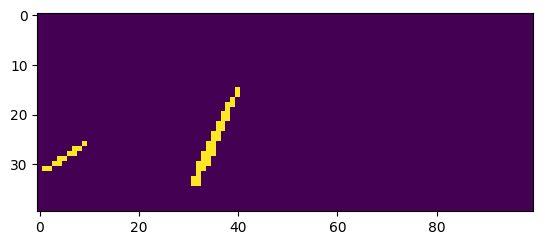

In [10]:
def show_thr_mask(result_list: list, idx, thr=0.4):
    """_summary_

    Args:
        result_list (list): a list
        idx (_type_): _description_
        thr (float, optional): _description_. Defaults to 0.4.
    """
    data_item = result_list[idx]['out']
    hm = get_hm(data=data_item)
    plt.imshow(hm > thr)
    
show_thr_mask(result_list=res, idx=4)

img_path:  /disk/gaoyao/dataset/culane/driver_100_30frame/05251517_0433.MP4/01050.jpg
txt_path:  /disk/gaoyao/dataset/culane/driver_100_30frame/05251517_0433.MP4/01050.lines.txt


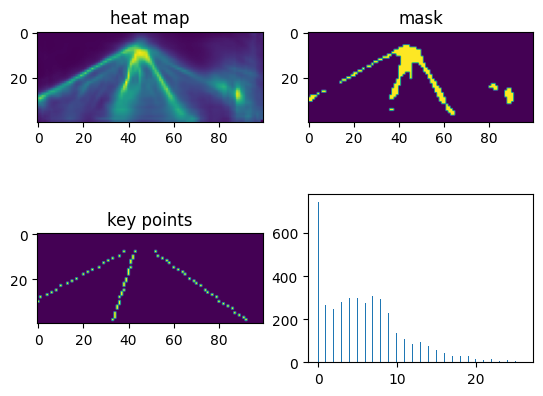

In [11]:
def show_res(result_list: list, idx, thr=0.4):
    data_item = result_list[idx]['out']
    data_gt = result_list[idx]['data']
    
    # get key point map
    txt_path = get_txt_path(data_gt)
    path = get_img_path(data_gt)
    # img = np.array(Image.open(path))
    print("img_path: ", path)
    print("txt_path: ", txt_path)
    lines = read_lane_lines(txt_path)
    # print("ground truth: ",lines)
    kpts = draw_kpts(lines)    
    
    # plot ground truth point on heat map:
    hm = get_hm(data=data_item)

    plt.subplot(221)
    plt.imshow(hm)
    # plt.imshow(np.minimum(kpts + hm, 1) )
    plt.title("heat map")
    plt.subplot(222)
    plt.imshow(hm > thr)
    plt.title("mask")
    plt.subplot(223)
    plt.imshow(kpts)
    plt.title("key points")
    plt.subplot(224)
    img = hm.ravel()
    if img.max() <= 1 + 1e-6:
        img = (img * 255)
    hist = plt.hist(img.astype('int'), 256)[0]
    # plt.imshow(img)
    
    return hm , hist 
hm,hist = show_res(res, 5, thr=15/255)


In [12]:
# 

In [13]:
# plt.imshow(get_hm(res[0]['out'])>0.4)
# plt.imshow(hm)
# plt.imshow(hm - hm.min())
# show_hist(hm=hm - hm.min())

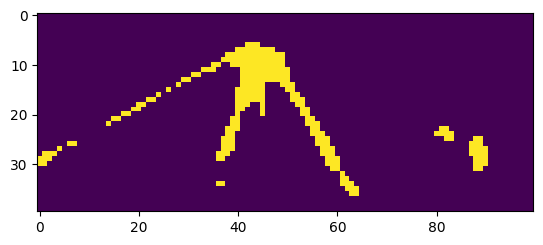

In [14]:
img = (hm - hm.min()) * 255
plt.imshow(img>15)

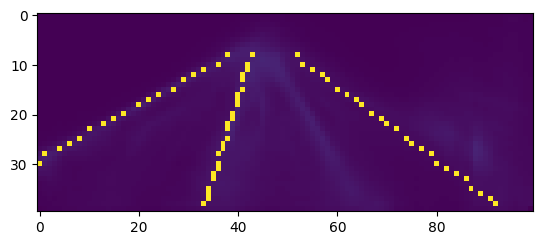

In [15]:
plt.imshow(np.minimum(kpts + hm, 1))

In [16]:
lines[0]

array([[-0.49099695, 30.        ],
       [ 1.78222561, 28.75      ],
       [ 4.0805122 , 27.5       ],
       [ 6.37878049, 26.25      ],
       [ 8.67707317, 25.        ],
       [10.97536585, 23.75      ],
       [13.27365854, 22.5       ],
       [15.57195122, 21.25      ],
       [17.8702439 , 20.        ],
       [20.16006098, 18.75      ],
       [22.45835366, 17.5       ],
       [24.75664634, 16.25      ],
       [27.05493902, 15.        ],
       [29.35323171, 13.75      ],
       [31.65152439, 12.5       ],
       [33.94981707, 11.25      ],
       [36.24804878, 10.        ],
       [38.48743902,  8.75      ]])

In [17]:
inf = hm > 15/255
g = dict()
points = np.array(list(np.where(inf))).T
for y,x in points:
    if g.get(y, None) is None:
        g[y] = []
    else:
        g[y].append(x)
for y in g:
    g[y] = np.array(sorted(g[y]))

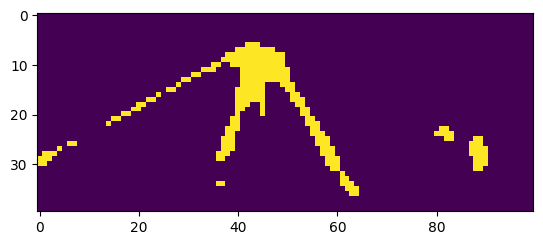

In [18]:
plt.imshow(hm > 15/255)

### step 1) Denoise

In [19]:

def denoise(g):
    clusters = dict()
    for row in g:
        # clusters = []
        points = list(g[row]) 
        if len(points) == 0: # points list is empty
            continue  
        
        # cumsum calculation:
        pre = [0] * len(points) 
        pre[0] = points[0] 
        for i in range(len(points) - 1):
            pre[i+1] = points[i+1] + pre[i] 
        
        # get clusters boundary in ordered list: 
        boundarys = []
        for i in range(len(points) - 1):
            if points[i+1] - points[i] > 5:
                boundarys.append(i)    # len(points) - 1 is always unavailable for i 
        boundarys.append(len(points) - 1)
        
        # clusters centers calculation: 
        clusters[row] = []  
        left = -1 
        for right in boundarys: 
            if left < 0:    # the first cluster
                clusters[row].append(pre[right] / (right + 1))     
            else:    # not the 1st cluster
                # assert right > left
                clusters[row].append((pre[right] - pre[left]) / (right - left))    
            left = right  
    return clusters
# denoise(g)

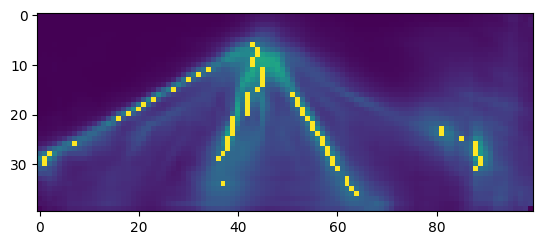

In [20]:
def show_clusters(clusters: dict, hm: np.ndarray):
    # to normalize the heat map:
    img = hm - hm.min() 
    img /= img.max() 
    img *= 0.618
    
    # to hilight the clusters:
    for row in clusters: 
        for col in clusters[row]:
            img[row][int(col)] = 1
    plt.imshow(img) 
    
show_clusters(denoise(g), hm)

In [21]:
from collections import OrderedDict
from copy import deepcopy

In [22]:
# deepcopy(clusters)
# len(clusters)
# clusters

# return cosine similarity of two vectors
def cos_similarity(r_vanishing, c_vanishing, r1, c1, r2, c2):
    v1 = (r1 - r_vanishing, c1 - c_vanishing) 
    v2 = (r2 - r_vanishing, c2 - c_vanishing)    
    V1 = (v1[0]**2 + v1[1]**2) ** 0.5 
    V2 = (v2[0]**2 + v2[1]**2) ** 0.5
    if V1 == 0 or V2 == 0: 
        return 0
    return (v1[0] * v2[0] +  v1[1] * v2[1]) / (V1 * V2)


def distance(r1, c1, r2, c2):
    return ((r1 - r2)**2 + (c1 - c2)**2) ** 0.5
    
     
cos_similarity(0,0, 1,1,0,1)    # sqrt(2) / 2

0.7071067811865475

In [23]:
denoise(g)

{6: [43.5],
 7: [44.0],
 8: [44.0],
 9: [43.5],
 10: [43.333333333333336],
 11: [34.5, 45.5],
 12: [32.0, 45.5],
 13: [30.0, 45.5],
 14: [45.625],
 15: [27.0, 44.5],
 16: [42.5, 51.5],
 17: [23.0, 42.5, 52.0],
 18: [21.0, 42.0, 52.5],
 19: [20.0, 42.0, 53.5],
 20: [18.0, 42.5, 53.5],
 21: [16.0, 39.5, 54.5],
 22: [39.5, 55.0],
 23: [39.5, 55.5, 81.5],
 24: [39.0, 56.0, 81.5],
 25: [38.5, 57.0, 85.5],
 26: [7.0, 38.0, 57.0, 88.0],
 27: [38.0, 58.0, 88.5],
 28: [2.5, 37.0, 58.0, 88.5],
 29: [1.5, 36.5, 59.0, 89.0],
 30: [1.0, 59.0, 89.0],
 31: [60.0, 88.5],
 33: [62.0],
 34: [37.0, 62.0],
 35: [63.5],
 36: [64.0]}

### step 2) interpolation

In [24]:

def lane_assignment(clusters):
    start_pt_r = -1    # row index of start point 
    start_pt_c = -1    # column index of start point

    # vanishing point calculation:
    for row in clusters:
        top = clusters.pop(row)    # type: list
        start_pt_c = sum(top) / len(top)
        start_pt_r = row
        # del top  
        break

    # init the lanes:
    # every point is in different lanes
    lanes = []
    for row in clusters:
        for col in clusters[row]:
            lanes.append([(row, col)]) 
        clusters.pop(row) 
        break  

    # two pointers algorithmn:
    theta_thr = 3**0.5 / 3    # cos30°
    for row in clusters:
        cls_lane = 0
        for i,col in enumerate(clusters[row]):    # every col is in differnet lanes    
            if cls_lane >= len(lanes):
                lanes.append([(row, col)])    # create a new lane
            else:
                top = lanes[cls_lane][-1]    # to try whether the nearest point is top
                while distance(row, col, top[0], top[1]) >= 5 and cos_similarity(start_pt_r, start_pt_c, row, col, top[0], top[1]) <= theta_thr:
                    cls_lane += 1
                    if cls_lane >= len(lanes):    # out of index
                        lanes.append([])    # create a new lane
                        break 
                    top = lanes[cls_lane][-1]
                lanes[cls_lane].append((row, col))     
            cls_lane += 1         

    return lanes
        
lane_assignment(denoise(g))
        

[[(7, 44.0),
  (8, 44.0),
  (9, 43.5),
  (10, 43.333333333333336),
  (14, 45.625),
  (16, 42.5),
  (22, 39.5),
  (23, 39.5),
  (24, 39.0),
  (25, 38.5),
  (26, 7.0),
  (27, 38.0),
  (28, 2.5),
  (29, 1.5),
  (30, 1.0),
  (34, 37.0),
  (35, 63.5),
  (36, 64.0)],
 [(11, 34.5),
  (12, 32.0),
  (13, 30.0),
  (15, 27.0),
  (17, 23.0),
  (18, 21.0),
  (19, 20.0),
  (20, 18.0),
  (21, 16.0),
  (26, 38.0),
  (27, 58.0),
  (28, 37.0),
  (29, 36.5),
  (30, 59.0),
  (31, 60.0),
  (33, 62.0),
  (34, 62.0)],
 [(11, 45.5),
  (12, 45.5),
  (13, 45.5),
  (15, 44.5),
  (16, 51.5),
  (17, 42.5),
  (18, 42.0),
  (19, 42.0),
  (20, 42.5),
  (21, 39.5),
  (22, 55.0),
  (23, 55.5),
  (24, 56.0),
  (25, 57.0),
  (26, 57.0),
  (27, 88.5),
  (28, 58.0),
  (29, 59.0),
  (30, 89.0),
  (31, 88.5)],
 [(17, 52.0),
  (18, 52.5),
  (19, 53.5),
  (20, 53.5),
  (21, 54.5),
  (23, 81.5),
  (24, 81.5),
  (25, 85.5),
  (26, 88.0),
  (28, 88.5),
  (29, 89.0)]]

In [25]:
# plt.imshow(hm - hm.min())
lanes[1]




NameError: name 'lanes' is not defined

{6: array([43, 44]),
 7: array([41, 42, 43, 44, 45, 46, 47]),
 8: array([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 9: array([38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 10: array([36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 11: array([34, 35, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 12: array([32, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 13: array([30, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]),
 14: array([41, 42, 43, 44, 45, 49, 50, 51]),
 15: array([27, 40, 41, 42, 43, 44, 45, 50, 51]),
 16: array([40, 41, 42, 43, 44, 45, 51, 52]),
 17: array([23, 40, 41, 42, 43, 44, 45, 51, 52, 53]),
 18: array([21, 40, 41, 42, 45, 52, 53]),
 19: array([20, 40, 41, 45, 53, 54]),
 20: array([18, 40, 45, 53, 54]),
 21: array([16, 39, 40, 54, 55]),
 22: array([39, 40, 54, 55, 56]),
 23: array([39, 40, 55, 56, 81, 82]),
 24: array([39, 55, 56, 57, 80, 81, 82, 83]),
 25: array([38, 39, 56, 57, 58, 82, 83, 88, 89]),
 26: array([ 7, 37, 38, 39, 56, 57, 58, 87, 88, 89]),
 27: array([37

In [ ]:
c1 = g[22][:3]
c2  =g[22][3:5]
c3 = g[22][5:]
def loss(*args):
    l = []
    for c in args:
        l.append(abs((c - c.sum()/len(c)).mean()))
    return sum(l) / len(l)
# c1 - c1.sum()/len(c1), c2 - c2.sum()/len(c2), c3 - c3.sum()/len(c3)
loss(g[22])

2.0301221021717147e-15

In [ ]:
# g[22] 
[1,2,3,4]

[1, 2, 3]

In [ ]:
shown = get_numpy(data_item['kpts_hm'])[0,0]
shown.shape

(40, 100)

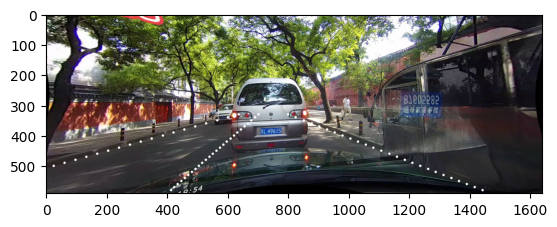

In [ ]:
lines = read_lane_lines(path)
plt.imshow(draw_lanes_on_img(lines, img, y_cut=0, sz=(590, 1640)))

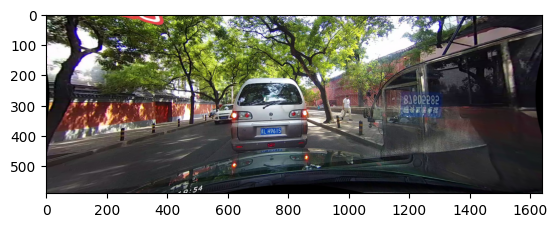

In [ ]:
plt.imshow(img.flatten().reshape((590, 1640, -1)))

In [ ]:
# cv2.imsave('1.jpg', shown)

In [ ]:
# if not os.path.exists('img'):
#     os.mkdir('img')
    
# for i, data in enumerate(res):
#     data = data['data']
#     img = np.array(Image.open(get_img_path(data=data)))
#     lines = read_lane_lines(get_txt_path(data=data))
#     vis = draw_lanes_on_img(lines, img, y_cut=0, sz=(590, 1640))
#     plt.imsave('img/' + str(i) + '.jpg', vis)

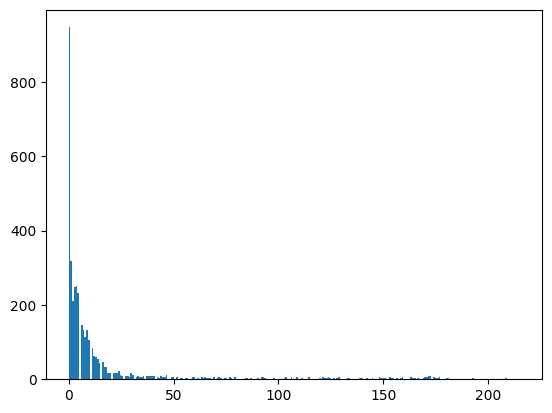

In [ ]:
hist = plt.hist((shown * 255).astype('int').ravel(), 256)[0]

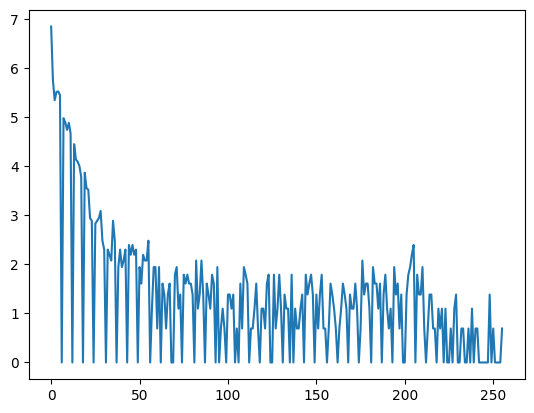

In [ ]:
plt.plot(np.arange(256),np.log(hist + 1))

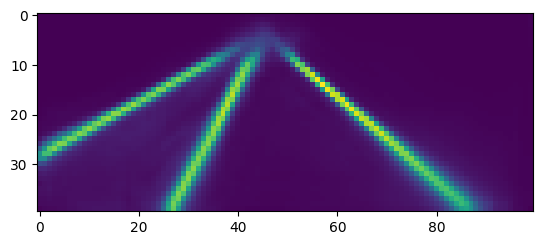

In [ ]:
plt.imshow(get_hm(data_item))

In [ ]:
# [k for k in data_item]
get_numpy(data_item['kpts_hm'])[0,0]

(40, 100)

In [ ]:
data_item['kpts_hm'].shape

torch.Size([1, 1, 40, 100])

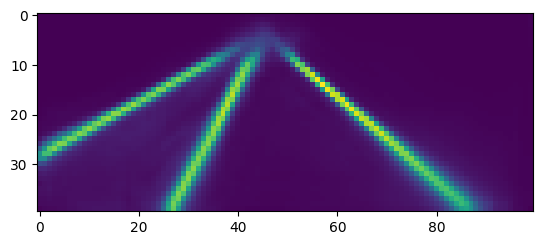

In [ ]:
# data_item = res[3]
plt.imshow(get_numpy(data_item['kpts_hm'])[0,0])

In [ ]:
# net(**data)

In [ ]:
s = []
for i in range(int(1e8)):
    s.append(i)

In [ ]:
# [i for i in range(int(1e8))]

In [ ]:
# [k for k in model]

model